In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 

## Part 1 - Exploratory Data Analysis

In [2]:
f = open('logins.json')
logins = json.load(f)
f.close()

In [3]:
print(logins.keys())
print(logins['login_time'][:5])
print(len(logins['login_time']))

dict_keys(['login_time'])
['1970-01-01 20:13:18', '1970-01-01 20:16:10', '1970-01-01 20:16:37', '1970-01-01 20:16:36', '1970-01-01 20:26:21']
93142


We can see that the login information is formatted in a dictionary with a single key and then a list of over 90K login times. Let's convert this to a dataframe so that we can use pandas datetime format to our advantage. 

In [4]:
logins = pd.DataFrame(logins)
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [6]:
logins['login_time'] = pd.to_datetime(logins['login_time'])

In [7]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [8]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [9]:
## now let's make the logins the index

logins = logins.reset_index()
#logins.head()
logins = logins.set_index('login_time')
logins.drop('index', axis=1, inplace=True)
logins['count'] = 1
logins.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [10]:
##now to aggregate by 15 minute intervals 
logins = logins.resample('15T').sum()

In [11]:
logins.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [12]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


We can see that there are ~10K entries now for fifteen minute intervals in this data. 

The data spans from January 01, 1970 at 8pm to April 13th, 1970 6:45pm. 

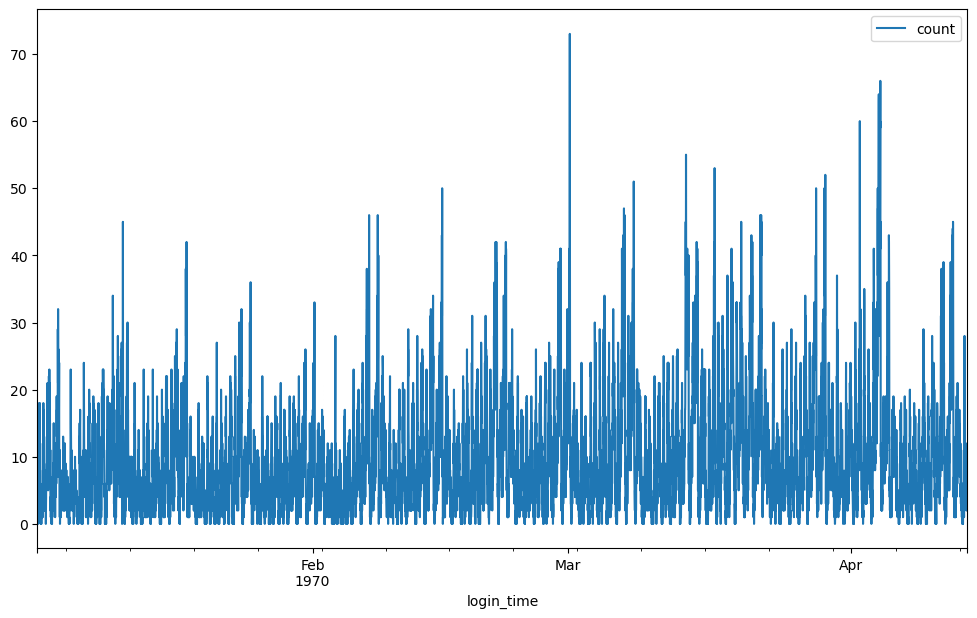

In [13]:
#plt.figure(figsize=(10,7))
logins.plot(figsize=(12,7))
plt.show()

There do appear to be some interesting patterns here. We can see some interesting cycles in the data. 

It would be helpful to zoom in. Let's take a look at what a single month looks like. 

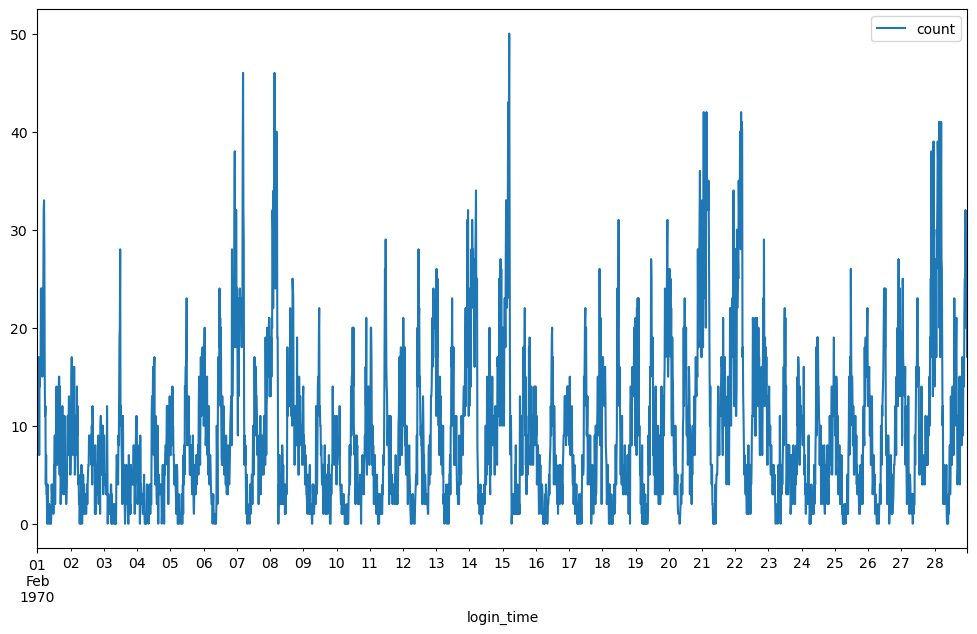

In [14]:
mask = (logins.index > '1970-01-31 23:45:00') & (logins.index < '1970-03-01 00:00:00')
feb = logins.loc[mask]

feb.plot(figsize=(12,7))
plt.show()

We can see that there are still fairly regular periods of up and down within a single month. It also appears that there are some higher peaks occurring roughly every seven days, occurring on the weekends. 
Let's look at one week. 

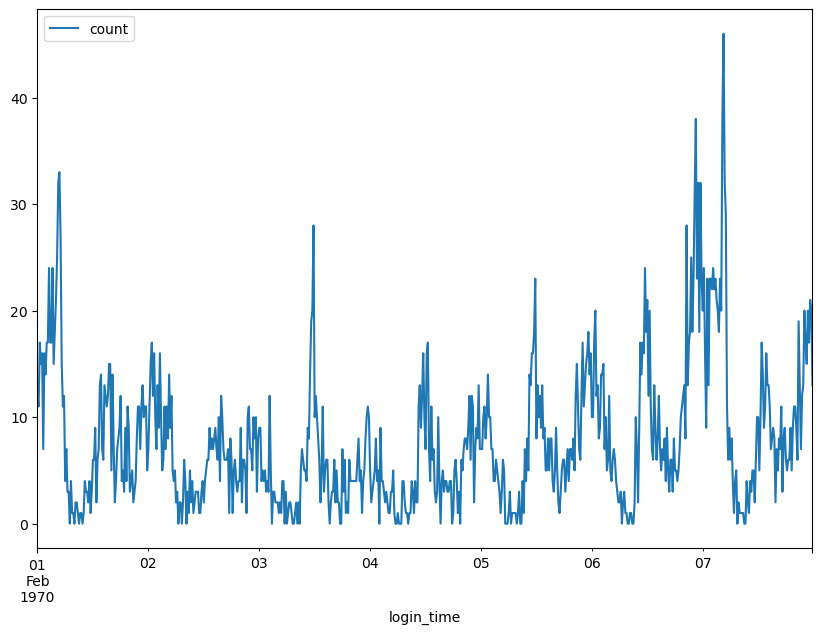

In [15]:
week = (logins.index > '1970-01-31 23:45:00') & (logins.index < '1970-02-08 00:00:00')
feb_week = logins.loc[week]

feb_week.plot(figsize=(10,7))
plt.show()

Interestingly, it appears as though the peaks occur roughly twice a day, every twelve hours. 

And finally, let's look at the changes over the course of a single day. 

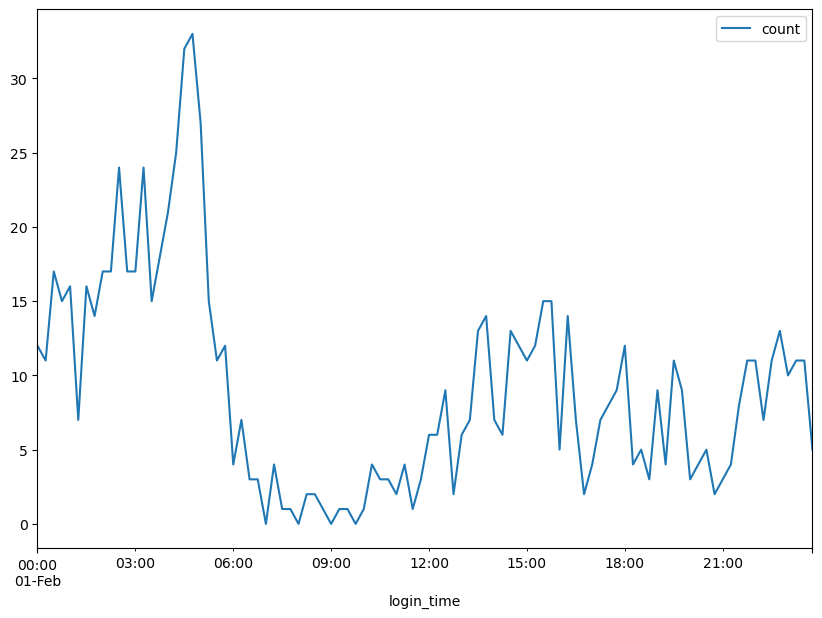

In [16]:
day = (logins.index > '1970-01-31 23:45:00') & (logins.index < '1970-02-02 00:00:00')
feb_day = logins.loc[day]

feb_day.plot(figsize=(10,7))
plt.show()

This plot also shows what we expected from the weekly plot - that there is a rise in logins in the early morning and then another peak in the early afternoon. 

### Summary 

By visually inspecting these patterns in our data, we can generally conclude that the highest numbers of logins occur on the weekends, and that on a daily basis, our pattern of logins generally peaks twice a day, in the morning and the early afternoon, every twelve hours. 

## Part 2 - Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1.What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2.Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
- how you will implement the experiment
- what statistical test(s) you will conduct to verify the significance of the observation
- how you would interpret the results and provide recommendations to the city operations team along with any caveats

### Answer

#### 1
The metric I would choose would be the average ratio of trips that drivers take in each city. The idea being that drivers native to Ultimate Gotham currently have a ratio that is skewed in favor of Ultimate Gotham (taking very few trips in Ultimate Metropolis) and vice versa, so if we can affect that ratio so that it is closer to 1 (meaning that the number of trips taken in both cities is closer to equal, leading to a 1:1 ratio), we have been more successful in encouraging drivers to be available in both cities. 

#### 2
To perform this experiment, first you will need to start collecting data on drivers' trips for at least several weeks to several months before implementing the reimbursement system. This way we can see what our baseline ratio is in order to compare how the reimbursement system actually affects the drivers' behavior. 

Next, we will implement the reimbursement system, while continuing to closely monitor the average ratio of trips made in each city. We can expect that if drivers' behavior is affected, the change will occur gradually over time, so we will want to monitor the percent change in the average ratio of trips to see the rate of change in general availability of drivers in both cities. We will need to perform statistical significance tests, specifically A/B tests, in order to accept or reject our null hypothesis (that reimbursing drivers for the toll bridge does not significantly affect the average ratio of trips that drivers take in both cities). We will need to see a statistical significance level p_value=0.05 in order to accept that this change is significant. 

We will need to establish what the Ultimate managers would like to see as a "successful" percent change in average ratio of trips. We will also need to determine how long they are willing to carry out the experiment in order to arrange the timing of everything as well (e.g. how long to measure daily average ratios before reimbursing drivers and how long to measure afterward before concluding that percent change is significant/insignificant). 

## Part 3 - Predictive Modeling

### EDA

In [2]:
ultimate = pd.read_json('ultimate_data_challenge.json')
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We can see that there a few missing values here in the avg_rating_of_driver, phone, and avg_rating_by_driver columns. We will definitely need to drop users that are missing a phone number, as this is essentially the person's ID. We will also need to pick our target feature here that we can use to determine whether a user has been retained or not. 

We are trying to determine if a user will be active in their sixth month in the system. We consider someone active if they have taken a ride within the last month. 

In [4]:
ultimate['signup_date'] = pd.to_datetime(ultimate['signup_date'])
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])

ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [5]:
#ultimate = ultimate.dropna(subset='phone')
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

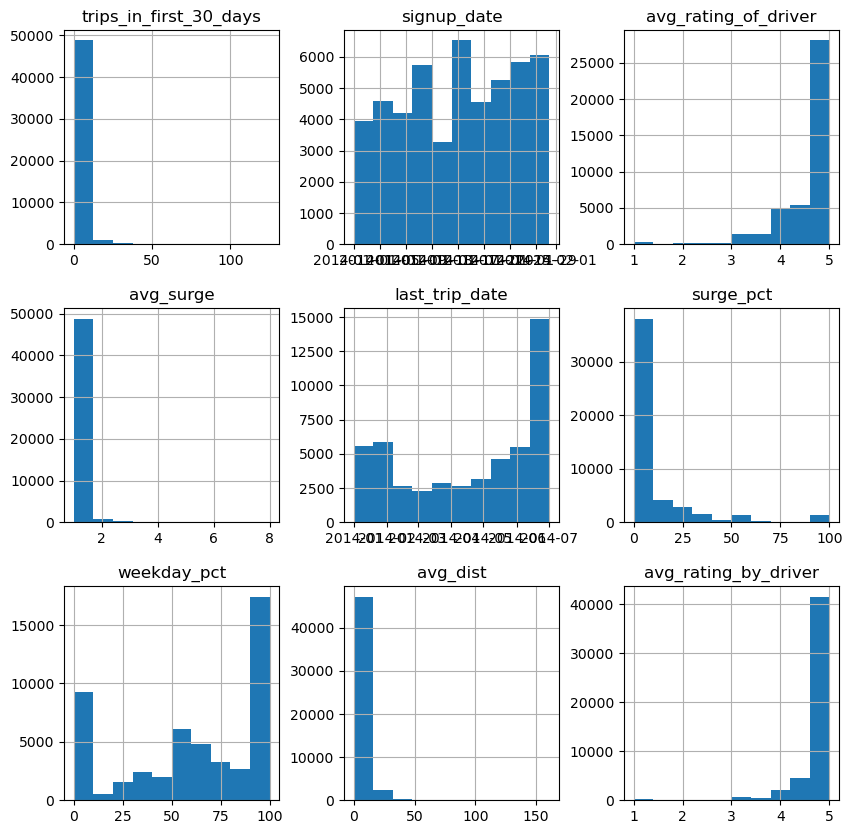

In [6]:
ultimate.hist(figsize=(10,10))
plt.show()

From these charts, some general observations: 

- trips in first 30 days: vast majority of users take very few trips in their first 30 days 
- vast majority of drivers get a 5.0 rating from users 
- vast majority of users have an average surge multiplier very close to zero 
- surge percent is also very close to zero for most users
- weekday percent (percent of trips occurring on a weekday) is a fairly broad range with peaks at 0, 50, and 100 showing that perhaps users fall into discrete categories here depending on their reason for using the service
- average distance is the average distance in miles per trip taken in the first 30 days after signup -- this number also appears to tend in the lower ranges
- average rating by driver also tends to mostly stay close to 5.0 with very few exceptions in the lower ranges\

I don't want to yet get rid riders that have not given their drivers ratings or vice versa as I am curious to see if the lack of data here is due to a correlation with customers that are not retained. 

This data is from customers who signed up January. We want to see if they are still active at least 5 months and 1 day after they have registered. We will consider a month to be 30 days for this purpose. Therefore, we are looking for people who are active at least 151 days after they registered (these are considered active in their sixth month).  

In [7]:
#ultimate['retained'] = ultimate['last_trip_date'] > '2014-06-01'
ultimate.head()

#(ultimate['last_trip_date'] - ultimate['signup_date']).days
retained = []
for index,row in ultimate.iterrows():
    start_date = row['signup_date']
    last_trip = row['last_trip_date']
    #print((last_trip - start_date).days)
    days = (last_trip - start_date).days
    if days >= 151:
        retained.append(1)
    else:
        retained.append(0)
        
ultimate['retained'] = retained

In [8]:
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [9]:
ultimate.retained.value_counts()

retained
0    37802
1    12198
Name: count, dtype: int64

In [10]:
print(f'Fraction of retained users is {12198 / (12198 + 37802)}')

Fraction of retained users is 0.24396


Now let's investigate a little deeper the role each featuer has related to our target feature. 

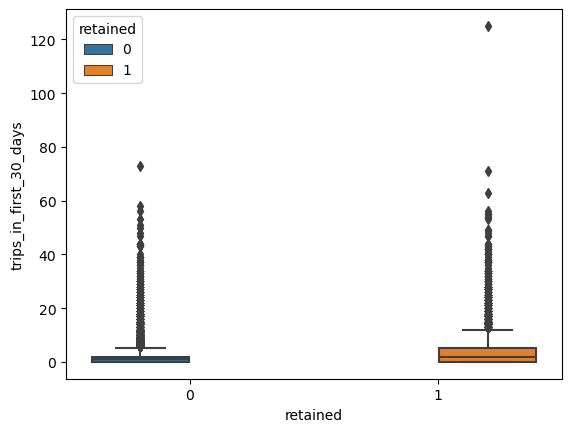

In [11]:
sns.boxplot(data=ultimate, x='retained', y='trips_in_first_30_days', hue='retained')
plt.show()

In [12]:
ultimate.loc[ultimate['trips_in_first_30_days'] > 100]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8,1


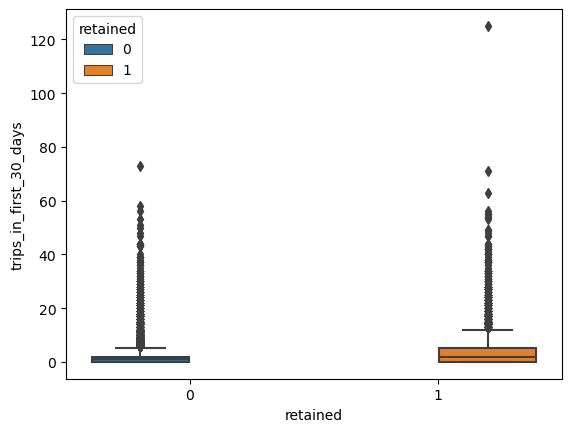

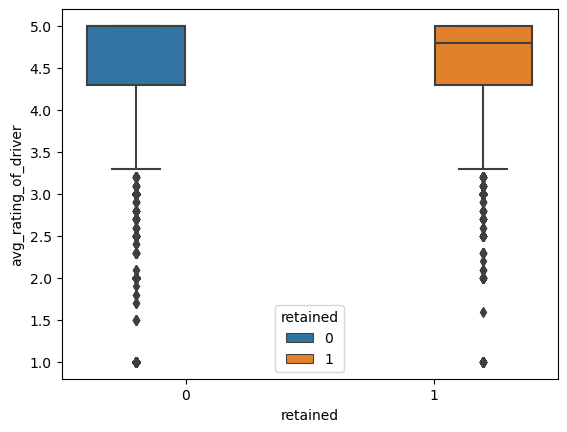

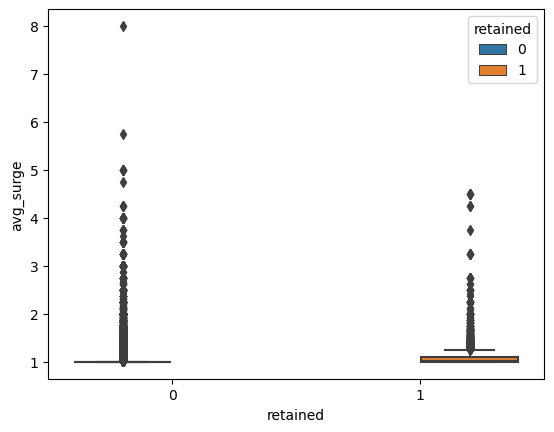

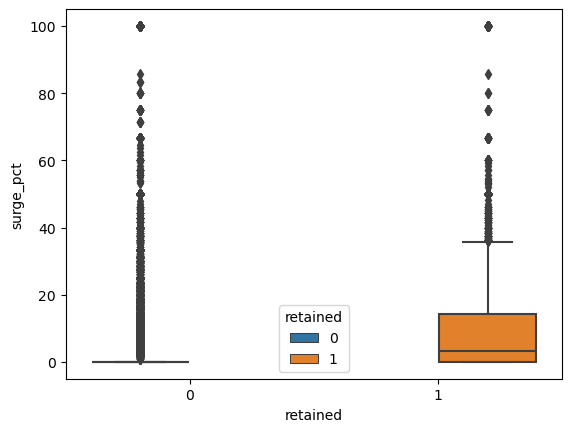

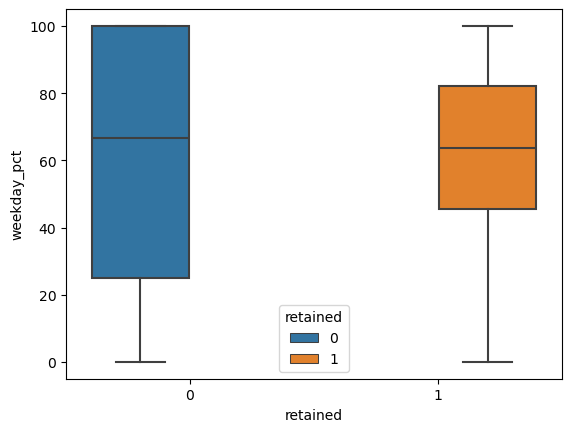

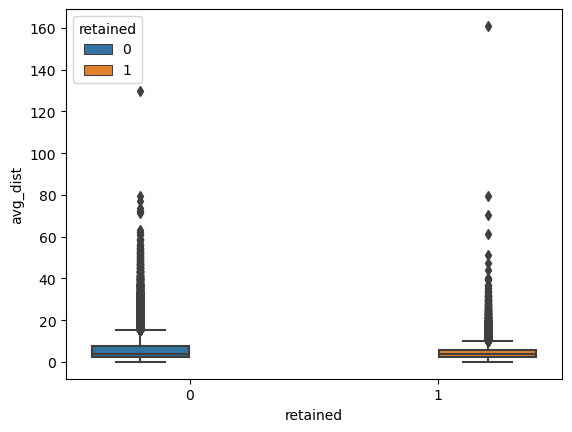

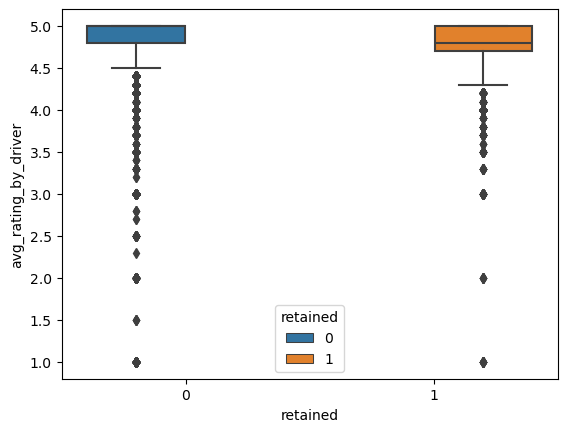

In [13]:
#print(ultimate.columns)
features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 
            'avg_dist', 'avg_rating_by_driver']

for feature in features:
    sns.boxplot(data=ultimate, x='retained', y=feature, hue='retained')
    plt.show()

From these features, we can see that there are slight differences in the distributions, but we would need to look a bit more in-depth to see them more clearly. 

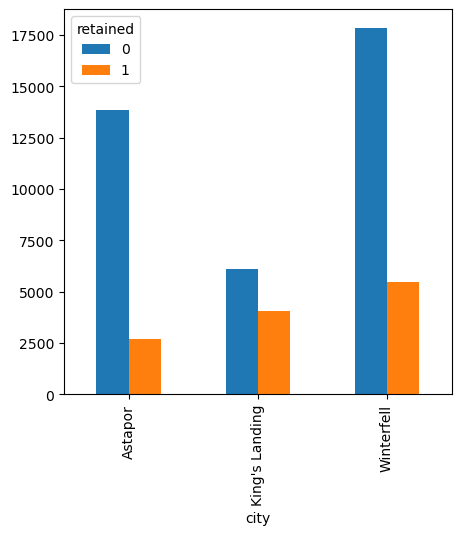

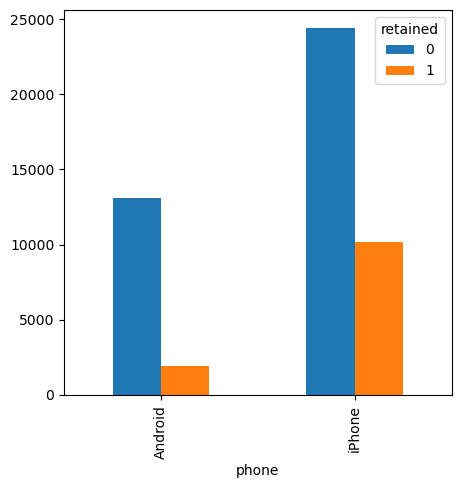

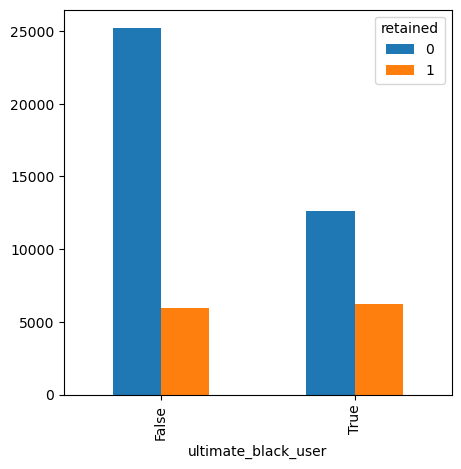

In [14]:
#ultimate.head()
cat_features = ['city', 'phone', 'ultimate_black_user']
for feature in cat_features:
    
    ax = ultimate.groupby(['retained'])[feature].value_counts().unstack(0).plot(kind='bar', figsize=(5,5))
    plt.show()

From these plots, we can see that King's Landing is the only city with a greater distribution of users retained. Additionally, it appears that there are more iPhone users overall just in general and that while the number who are not retained is higher than those who are retained, still more are retained than android users. Finally, people who register as ultimate black users seem to be equally likely to be retained as not, if you are not retained, seems you are more likely to *not* be an ultimate black user.



### Predictive Modeling

In [15]:
## Now let's take a peak at the categorical features 

## first let's transform them into a more easily usable form 

ultimate = pd.get_dummies(data=ultimate, columns=['city', 'phone', 'ultimate_black_user'], dtype='int')
ultimate.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


In [37]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   trips_in_first_30_days     50000 non-null  int64         
 1   signup_date                50000 non-null  datetime64[ns]
 2   avg_rating_of_driver       41878 non-null  float64       
 3   avg_surge                  50000 non-null  float64       
 4   last_trip_date             50000 non-null  datetime64[ns]
 5   surge_pct                  50000 non-null  float64       
 6   weekday_pct                50000 non-null  float64       
 7   avg_dist                   50000 non-null  float64       
 8   avg_rating_by_driver       49799 non-null  float64       
 9   retained                   50000 non-null  int64         
 10  city_Astapor               50000 non-null  int64         
 11  city_King's Landing        50000 non-null  int64         
 12  city

Now let's identify what to do with our missing values. We are missing values in the avg_rating_of_driver and avg_rating_by_driver columns. Let's just replace these values with the most frequently occurring values in their category. 

In [62]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
features = ultimate.drop(columns=['signup_date', 'last_trip_date', 'retained'], axis='columns')
X = np.array(features)
target = np.array(ultimate[['retained']])
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=42, stratify=target)
imp_mean.fit(X_train) 
X_train = imp_mean.transform(X_train) 
X_test = imp_mean.transform(X_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37500, 14)
(12500, 14)
(37500, 1)
(12500, 1)


In [39]:
from sklearn.preprocessing import StandardScaler

ss_scaler = StandardScaler()

ss_scaler.fit(X_train) 

X_train = ss_scaler.transform(X_train) 
X_test = ss_scaler.transform(X_test)

In [40]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train.ravel())

RandomForestClassifier()

In [41]:
y_preds = model.predict(X_test)

In [42]:
from sklearn.metrics import classification_report
target_names = ['not_retained', 'retained']
print(classification_report(y_test, y_preds, target_names=target_names))

              precision    recall  f1-score   support

not_retained       0.83      0.88      0.85      9451
    retained       0.54      0.45      0.49      3049

    accuracy                           0.77     12500
   macro avg       0.68      0.66      0.67     12500
weighted avg       0.76      0.77      0.76     12500



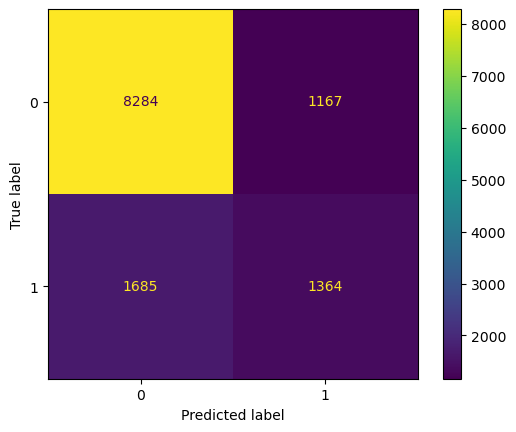

In [43]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

From this, we can see that out of the box, Random Forest seems to over-identify users as being not retained, and seems to struggle with identifying people who are retained accurately. 

Let's try tuning the parameters. 

In [46]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_estimators':[100, 200, 300], 
              'max_depth':[10, 30, 50, 70, 90, None],
             'criterion':['gini', 'entropy'], 
             'min_samples_leaf':[1, 2, 4]}

rf = RandomForestClassifier()

rs_model = RandomizedSearchCV(rf, param_distributions=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

In [47]:
rs_model.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 30, 50, 70, 90, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [100, 200, 300]},
                   scoring='accuracy', verbose=2)

In [50]:
cv_results = pd.DataFrame(rs_model.cv_results_)
cv_results.sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,6.512680,0.059017,0.248036,0.018276,200,4,10,gini,"{'n_estimators': 200, 'min_samples_leaf': 4, '...",0.795600,0.802400,0.790533,0.797200,0.795333,0.796213,0.003812,1
8,3.637275,0.063845,0.127271,0.014397,100,1,10,entropy,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",0.793333,0.803467,0.790533,0.797733,0.795467,0.796107,0.004381,2
5,8.398179,0.131356,0.392527,0.013833,200,4,50,gini,"{'n_estimators': 200, 'min_samples_leaf': 4, '...",0.799200,0.794800,0.789067,0.795733,0.796000,0.794960,0.003299,3
9,3.656724,0.334191,0.139893,0.022939,100,4,70,gini,"{'n_estimators': 100, 'min_samples_leaf': 4, '...",0.798000,0.796933,0.787867,0.792133,0.798267,0.794640,0.004046,4
6,4.243155,0.036100,0.207755,0.015419,100,4,50,gini,"{'n_estimators': 100, 'min_samples_leaf': 4, '...",0.796667,0.797867,0.788933,0.792800,0.793600,0.793973,0.003141,5


We can see from this that our best performing model has an accuracy of about 0.7962 on our testing data. It had the params of 200 estimators, minimum 4 samples per leaf, and a max-depth of 10, criterion='gini'. Let's now evaluate it on our testing data. 

In [54]:
rf_best = rs_model.best_estimator_

y_preds = rf_best.predict(X_test)

In [55]:
target_names = ['not_retained', 'retained']
print(classification_report(y_test, y_preds, target_names=target_names))

              precision    recall  f1-score   support

not_retained       0.83      0.93      0.88      9451
    retained       0.65      0.39      0.49      3049

    accuracy                           0.80     12500
   macro avg       0.74      0.66      0.68     12500
weighted avg       0.78      0.80      0.78     12500



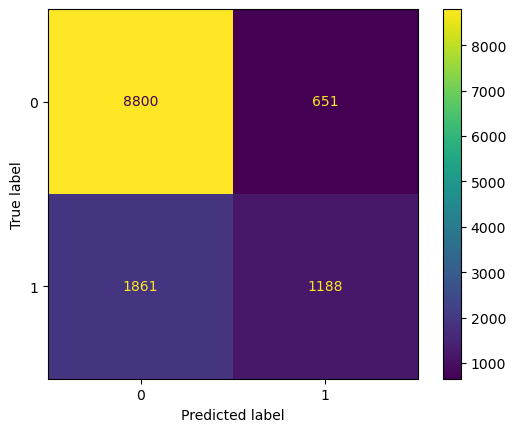

In [56]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

We can see here again the same sort of trends we observed with our random forest model with default parameters. Our overall accuracy (0.80) is comparable to the training set, which does not seem to indicate overfitting. 

However, we can see from the confusion matrix that our model tends to over-predict users who will not be retained. About 83% of those predicted to not be retained is correct. However, it has a very poor recall for users who are retained, meaning that it misses about 61% of users who are actually retained. For those that it does predict to be retained however, it is right about 65% of the time. 

### Feature Importance

In [65]:
print(rf_best.feature_importances_)
#print(rf_best.feature_names_in_)
print(features.columns)

feature_imp = pd.DataFrame(zip(list(rf_best.feature_importances_), list(features.columns)), columns=['Importance', 'Feature'])
feature_imp.head()

[0.06002965 0.06235001 0.10212478 0.17328798 0.11555387 0.06463501
 0.17675417 0.02810271 0.06900204 0.01330376 0.03785317 0.03783997
 0.02830595 0.03085693]
Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
       'city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_iPhone', 'ultimate_black_user_False',
       'ultimate_black_user_True'],
      dtype='object')


,Importance,Feature
0,0.060030,trips_in_first_30_days
1,0.062350,avg_rating_of_driver
2,0.102125,avg_surge
3,0.173288,surge_pct
4,0.115554,weekday_pct


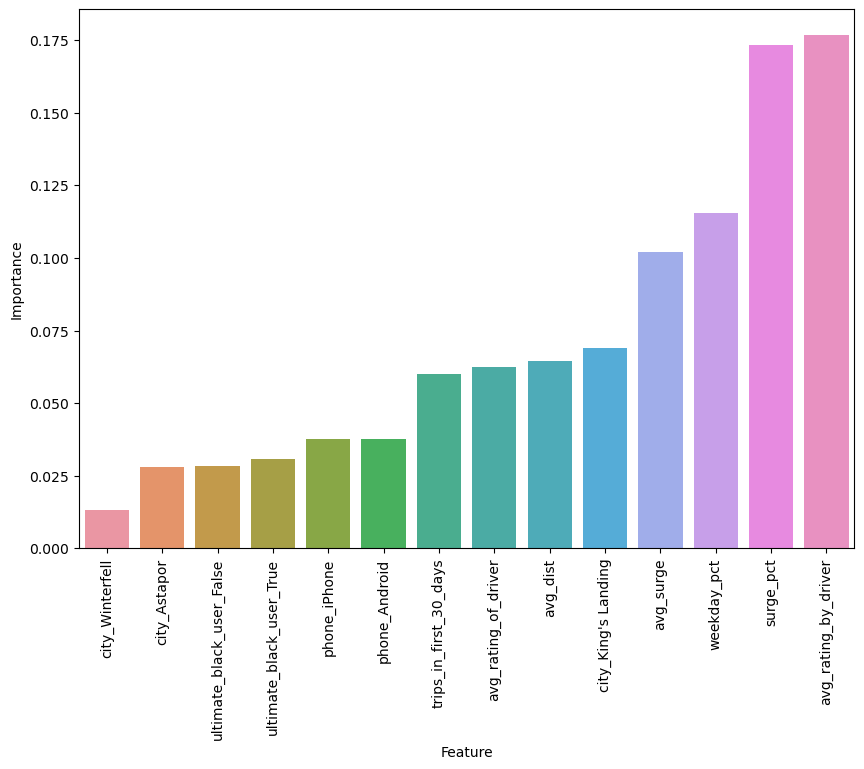

In [77]:
plt.figure(figsize=(10,7))
sns.barplot(data=feature_imp.sort_values('Importance'), x='Feature', y='Importance')
plt.xticks(rotation=90)
plt.show()

From this, we can see that the most important features for user retention are predicted by this model to be the average rating given by the driver, the surge percentage, weekday percentage, and average surge. We can see that overall the model does not think that the cities Winterfell or Astapor are important, or whether you are an ultimate black user or iphone or android user. 

Since our Random Forest regressor thinks that the weekday percentage is a significant attribute at play here, perhaps to drive up user retention, as well as trips in the first 30 days, we could offer a discount for users on weekdays in the first 30 days of their account. 